In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.interpolate import RBFInterpolator

Load in calibration images

In [2]:
buffer = 0
img = cv2.imread('rimage.png')
width = img.shape[1]
img = img[:, width//2 - buffer:]

Defines function to display image

In [3]:
def disp(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)

Defines function to automatically detect as many corners as possible

In [4]:
def getCorners(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, quality = cv2.goodFeaturesToTrackWithQuality(gimg, maxCorners=200, qualityLevel=0.10, minDistance=7, mask=None)
    return corners

Defines function to display corners

In [5]:
def displayCorners(img, corners, nums=True):
    _img = img.copy()
    for i in range(len(corners)):
        point = corners[i]
        cv2.circle(_img,(int(point[0][0]),int(point[0][1])),3,(0,0,255),-1)
        if nums:
            cv2.putText(_img,str(i),(int(point[0][0]),int(point[0][1])-2),0,0.5,(0,0,255))

    disp(_img)

Define Radial Basis Function

In [6]:
def getRBF(actual_corners, ideal_corners, additional_points):
    print(ideal_corners.shape)
    print(actual_corners.shape)

    filter = actual_corners[:,0,0] != -1.

    ideal_pair = np.squeeze(ideal_corners, axis=1)[filter]
    print(ideal_pair.dtype, ideal_pair.shape)

    actual_x = actual_corners[filter][:,0,0]
    print(actual_x.dtype, actual_x.shape)

    actual_y = actual_corners[filter][:,0,1]

    if additional_points is not None:
        actual_additional_points = additional_points[0]
        ideal_additional_points = additional_points[1]

        ideal_pair = np.concatenate((ideal_pair, ideal_additional_points))
        print("ideal", ideal_pair[-2:])

        actual_x = np.concatenate((actual_x, actual_additional_points[:,0]))
        print("actual x", actual_x[-2:])

        actual_y = np.concatenate((actual_y, actual_additional_points[:,1]))
        print("actual y", actual_y[-2:])

    rbf_x = RBFInterpolator(ideal_pair, actual_x)
    rbf_y = RBFInterpolator(ideal_pair, actual_y)

    return rbf_x, rbf_y, filter

Map image according coeficients

In [7]:
def undistort(img, new_shape, actual_corners, ideal_corners, additional_points=None):
    old_shape = img.shape[:2]
    fun_x, fun_y, filter = getRBF(actual_corners, ideal_corners, additional_points)

    x_off = 0 #old_shape[0] - new_shape[0]
    y_off = 0 #old_shape[1] - new_shape[1]

    map_x = np.zeros(new_shape, dtype=np.float32)
    map_y = np.zeros(new_shape, dtype=np.float32)
    for i in range(map_x.shape[0]):
        for j in range(map_x.shape[1]):
            map_x[i,j] = fun_x(np.array([[j+x_off, i+y_off]]))
            map_y[i,j] = fun_y(np.array([[j+x_off, i+y_off]]))

    return map_x, map_y, filter

Find potential corners

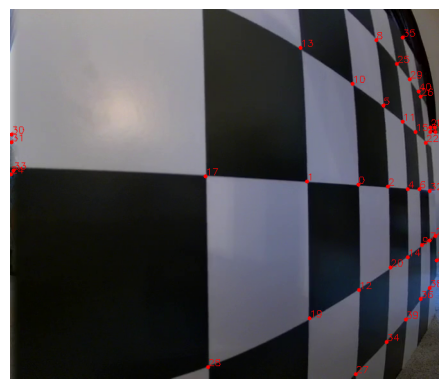

In [8]:
grid_height, grid_width = 7, 9

corn = getCorners(img)
displayCorners(img, corn)

Manually keep correct corners

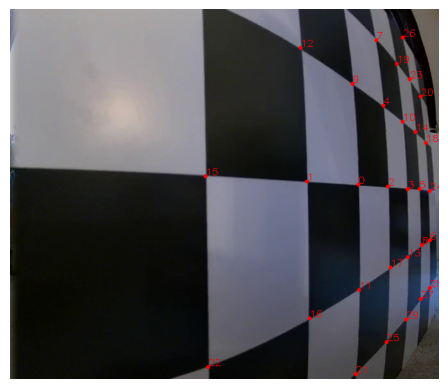

In [9]:
keep = [35, 8, 25, 29, 26, 13, 10, 5, 11, 15, 22, 17, 1, 0, 2, 4, 6, 32,
        28, 19, 12, 20, 14, 9, 7, 27, 34, 39, 36, 38]

mask = [False]*len(corn)
for k in keep:
    mask[k] = True
corn_n = corn[mask]

displayCorners(img, corn_n)

Lineup the indexes of the actual corners

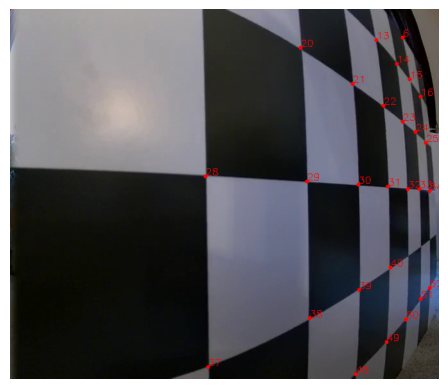

In [10]:
actual_corners = np.zeros((grid_height*grid_width, 1, 2))-1
map = {26:6,
       7:13, 19:14, 23:15, 20:16,
       12:20, 9:21, 4:22, 10:23, 14:24, 18:25,
       15:28, 1:29, 0:30, 2:31, 3:32, 5:33, 24:34,
       22:37, 16:38, 11:39, 17:40, 13:40, 8:40, 6:40,
       21:48, 25:49, 29:50, 27:51, 28:52}


assert (sorted(list(map.keys())) == list(range(len(corn_n)))), "map does not map all detected corner points"

for i in range(len(corn_n)):
    actual_corners[map[i]] = corn_n[i]

displayCorners(img, actual_corners)

Add Aditional Corners

(576, 668, 3)


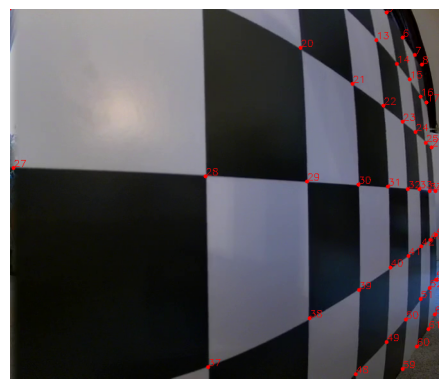

In [11]:
print(img.shape)

actual_corners[5] = np.array([[586, 5]])
actual_corners[7] = np.array([[630, 71]])
actual_corners[8] = np.array([[641, 86]])

actual_corners[17] = np.array([[648, 145]])

actual_corners[26] = np.array([[656, 215]])

actual_corners[27] = np.array([[5, 247]])
actual_corners[35] = np.array([[662, 283]])

actual_corners[41] = np.array([[620, 384]])
actual_corners[42] = np.array([[640, 369]])
actual_corners[43] = np.array([[654, 359]])
actual_corners[44] = np.array([[663, 351]])

actual_corners[53] = np.array([[663, 421]])

actual_corners[59] = np.array([[611, 560]])
actual_corners[60] = np.array([[633, 525]])
actual_corners[61] = np.array([[651, 498]])
actual_corners[62] = np.array([[661, 475]])

displayCorners(img, actual_corners)

Create ideal corner points

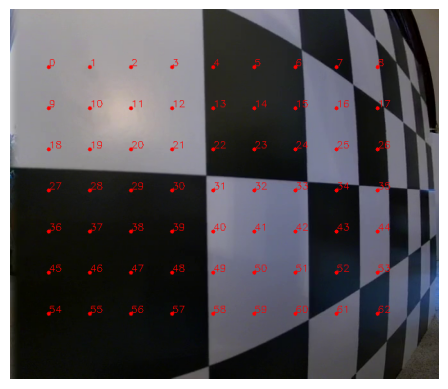

In [12]:
block_len = 64
height, width, _ = img.shape
ideal_corners = np.zeros((grid_height*grid_width, 1, 2))
start = np.array([60, 90])

for i in range(grid_height):
    for j in range(grid_width):
        ideal_corners[grid_width*i + j, 0] = start
        start[0] += block_len
    start[1] += block_len
    start[0] -= block_len*grid_width

displayCorners(img, ideal_corners)

Add Additional Points

In [13]:
additional_points = None

Get Callibration Matrix

In [18]:
map_x, map_y, filter = undistort(img, img.shape[:2], actual_corners, ideal_corners, additional_points)
map = np.stack((map_x, map_y), axis=2)

(63, 1, 2)
(63, 1, 2)
float64 (43, 2)
float64 (43,)
ideal [[ 60. 240.]
 [ 60. 330.]]
actual x [5. 5.]
actual y [  0. 576.]


Display Undistorted Image

In [2]:
per = cv2.remap(img, map, None, cv2.INTER_CUBIC)
displayCorners(per, ideal_corners[filter], False)

NameError: name 'cv2' is not defined

In [1]:
print(map.dtype)

AttributeError: type object 'map' has no attribute 'dtype'

Decide to add additional points

(576, 668, 3)
[[ 60. 282.]]
[[[  5.   0.]
  [  5. 576.]]

 [[ 60. 240.]
  [ 60. 330.]]]


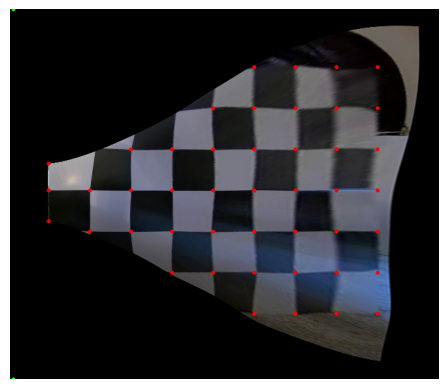

In [20]:
ideal_point1 = [60, 240]
actual_point1 = [5, 0]
ideal_point2 = [60, 330]
print(img.shape)
actual_point2 = [5, img.shape[0]]
print(ideal_corners[27])
_img = per.copy()

_img = cv2.circle(_img, ideal_point1, 3, (0,0,255), -1)
_img = cv2.circle(_img, actual_point1, 3, (0,255,0), -1)

_img = cv2.circle(_img, ideal_point2, 3, (0,0,255), -1)
_img = cv2.circle(_img, actual_point2, 3, (0,255,0), -1)
displayCorners(_img, ideal_corners[filter], False)

additional_points = np.array([[actual_point1, actual_point2], [ideal_point1, ideal_point2]], dtype=np.float64)
print(additional_points)

Improve resolution of rectifies image

In [27]:
scale = 3
scaled_additional_points = additional_points.copy()
scaled_additional_points[1] *= scale
#print((scale*ideal_corners)[~filter])
#displayCorners(per, (scale*ideal_corners)[filter], False)
map_x, map_y, filter = undistort(img, scale * np.array(img.shape[:2]), actual_corners, scale*ideal_corners, scaled_additional_points)
map = np.stack((map_x, map_y), axis=2)

(63, 1, 2)
(63, 1, 2)
float64 (43, 2)
float64 (43,)
ideal [[180. 720.]
 [180. 990.]]
actual x [5. 5.]
actual y [  0. 576.]


(1728, 2004, 3)


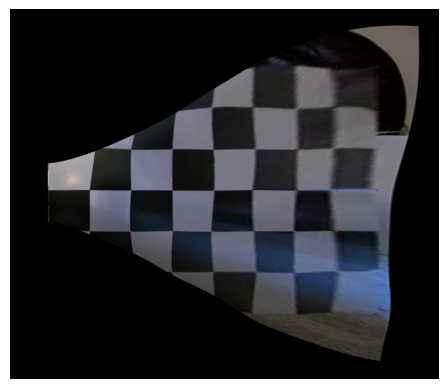

In [28]:
per = cv2.remap(img, map, None, cv2.INTER_CUBIC)

ideal_point1 = scale*additional_points[1,0].astype(int)
ideal_point2 = scale*additional_points[1,1].astype(int)
_img = per.copy()
_img = cv2.circle(_img, ideal_point1, 3, (0,0,255), -1)
_img = cv2.circle(_img, ideal_point2, 3, (0,0,255), -1)

print(per.shape)
displayCorners(_img, (scale*ideal_corners)[filter], False)

Save Callibration

In [29]:
np.save('./calibration_np/right_calibration.npy', map)